In [36]:
import os, time, librosa, librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam

import audio_data_loader as audioloader
import audio_data_writer as audiowriter
import references as ref

### Create Dataset

The dataset contains audio data prcessed. 


In [2]:
def get_features(y, sr):
    out = []
    
    out.append(np.mean(librosa.feature.rms(y = y)))
    out.append(np.mean(librosa.feature.spectral_centroid(y = y, sr = sr)))
    out.append(np.mean(librosa.feature.spectral_bandwidth(y = y, sr = sr)))
    out.append(np.mean(librosa.feature.spectral_rolloff(y = y, sr = sr))) 
    out.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    
    for e in librosa.feature.mfcc(y = y, sr = sr):
        out.append(np.min(e))
        out.append(np.mean(e))
        out.append(np.max(e))
        
   
    for e in librosa.feature.chroma_stft(y = y, sr = sr):
        out.append(np.min(e))
        out.append(np.mean(e))
        out.append(np.max(e))

    return out

In [3]:
def get_dataset(source):
    
    x_train = []
    y_train = []
    
    for i, item in tqdm(source.iterrows()):
        
        try:
            # read the audio file
            y, sr = audioloader.read_audio(item[0])
            
            # append x_train item
            x_train.append(get_features(y, sr))
            y_train.append(item[8])
            
        except:
            
            print(f'Invalid object {item[0]}')
            
    
    x_train, x_val, y_train, y_val = train_test_split(np.array(x_train), 
                                                      np.array(y_train), 
                                                      test_size = 0.1, 
                                                      random_state = 42, 
                                                      shuffle = True)        
        
    return x_train, x_val, y_train, y_val 

### Neural network model builder

In [69]:
def get_model(input_size):
    
    model = Sequential()
    model.add(Dense(200, activation = 'relu', input_shape = (input_size,)))
    model.add(Dense(120, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    return model

### Visualizations

In [28]:
def show_accuracy(data):
    
    fig, ax = plt.subplots(figsize = (15, 6))
    
    ax.plot(data.epoch, data.history['accuracy'], label = 'Accuracy')
    ax.plot(data.epoch, data.history['val_accuracy'], label = 'Validation Accuracy')
    
    plt.legend()
    plt.show()

### Training process

In [6]:
source = audioloader.create_source_dataset(ref.root_path)

Data source array is prepared - 0.015955448150634766 c


In [7]:
x_train, x_val, y_train, y_val = get_dataset(source)

1440it [10:55,  2.20it/s]


In [74]:
model = get_model(x_train.shape[1])

In [75]:
history = model.fit(x_train, y_train, batch_size = 50, epochs = 50, validation_split = 0.1)

Epoch 1/50
24/24 [==============================] - 1s 6ms/step - loss: 56.8033 - accuracy: 0.5206 - val_loss: 3.9138 - val_accuracy: 0.4923
Epoch 2/50
24/24 [==============================] - 0s 2ms/step - loss: 17.7664 - accuracy: 0.5660 - val_loss: 5.1875 - val_accuracy: 0.6308
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 8.1983 - accuracy: 0.6484 - val_loss: 3.9617 - val_accuracy: 0.7231
Epoch 4/50
24/24 [==============================] - 0s 2ms/step - loss: 3.4021 - accuracy: 0.7427 - val_loss: 1.0039 - val_accuracy: 0.8615
Epoch 5/50
24/24 [==============================] - 0s 2ms/step - loss: 3.1355 - accuracy: 0.6715 - val_loss: 1.5807 - val_accuracy: 0.7615
Epoch 6/50
24/24 [==============================] - 0s 2ms/step - loss: 1.5601 - accuracy: 0.7376 - val_loss: 0.8355 - val_accuracy: 0.7615
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 1.0121 - accuracy: 0.7719 - val_loss: 0.2429 - val_accuracy: 0.9154
Epoch 8/50
24/24 [

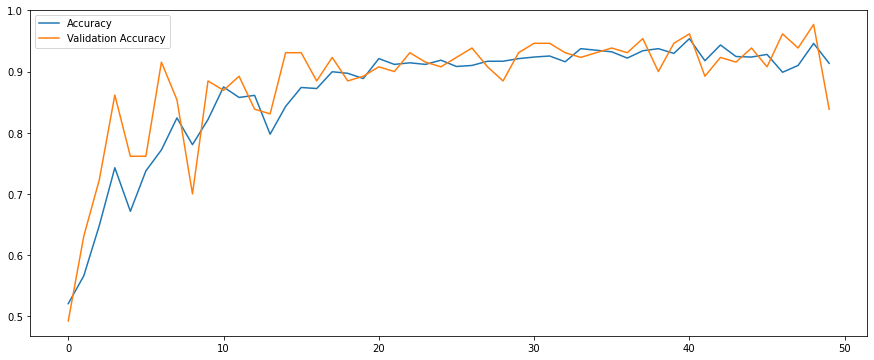

In [76]:
show_accuracy(history)

In [77]:
pred = model.evaluate(x_val, y_val)

5/5 [==============================] - 0s 2ms/step - loss: 0.3740 - accuracy: 0.8333


In [61]:
x = np.expand_dims(x_val[44], axis = 0)
y_pred = model.predict(x)
y_pred

array([[0.30676383]], dtype=float32)

### Sample Audio recording

In [95]:
audiowriter.write_audio()

* recording
* data recording


In [96]:
sample_filename = os.path.join(os.path.abspath(os.getcwd()), audiowriter.WAVE_OUTPUT_FILENAME)

In [97]:
print(sample_filename)

d:\DataSource\speech_project\output.wav


In [98]:
y, sr = audioloader.read_audio(sample_filename)

In [99]:
sound_sample = get_features(y, sr)

In [100]:
sound_sample = np.array(sound_sample)

In [101]:
sound_sample.shape

(101,)

In [102]:
x = np.expand_dims(sound_sample, axis = 0)

In [103]:
x.shape

(1, 101)

In [104]:
y_pred = model.predict(x)
y_pred

array([[0.9996836]], dtype=float32)